请将运行结果和图等实验步骤结果保留在jupyter之中

## 一、Pytorch基本操作考察

In [14]:
import numpy as np
import torch
from matplotlib import pyplot as plt 
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import os
import json
import torchvision 
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score

# 1.1

In [3]:
M = torch.rand((1,3))
N = torch.rand((2, 1))

In [4]:
# 第一种方式
result1 = M - N
print(result1)

tensor([[ 1.7416e-01,  2.0818e-01, -2.8788e-01],
        [ 4.6234e-01,  4.9635e-01,  2.9725e-04]])


In [5]:
# 第二种方式
result2 = torch.sub(M, N)
print(result2)

tensor([[ 1.7416e-01,  2.0818e-01, -2.8788e-01],
        [ 4.6234e-01,  4.9635e-01,  2.9725e-04]])


In [6]:
# 第三种方式 PyTorch 不允许在原地操作中触发自动广播行为！
M.sub_(N)
print(M)

RuntimeError: output with shape [1, 3] doesn't match the broadcast shape [2, 3]

# 1.2

In [7]:
# 均值为0，标准差为0.01的正态分布
mean = 0.0
std = 0.01
# 创建 P: 形状为 [3, 2]
P = torch.normal(mean=mean, std=std, size=(3, 2))
# 创建 Q: 形状为 [4, 2]
Q = torch.normal(mean=mean, std=std, size=(4, 2))
print("矩阵P", P)
print("矩阵Q", Q)

矩阵P tensor([[ 0.0173,  0.0038],
        [-0.0125, -0.0080],
        [-0.0004,  0.0053]])
矩阵Q tensor([[-0.0007, -0.0028],
        [ 0.0007,  0.0058],
        [ 0.0009,  0.0185],
        [ 0.0153,  0.0134]])


In [8]:
# 将Q进行转置
Q_T = Q.T
result = torch.mm(P, Q_T)
print(result)

tensor([[-2.2938e-05,  3.3762e-05,  8.6260e-05,  3.1488e-04],
        [ 3.1158e-05, -5.4277e-05, -1.5859e-04, -2.9678e-04],
        [-1.4601e-05,  3.0186e-05,  9.7705e-05,  6.5155e-05]])


# 1.3

In [9]:
x = torch.tensor(1.0, requires_grad=True)
print(x)

tensor(1., requires_grad=True)


In [10]:
y1 = x**2
print(y1)
with torch.no_grad():
    y2 = x**3
y3 = y1 + y2

tensor(1., grad_fn=<PowBackward0>)


In [11]:
if x.grad is not None:
    x.grad.zero_()
y3.backward(retain_graph=True) # 每次计算完梯度后会自动释放计算图retain_graph可以重复求导
print(x.grad)

tensor(2.)


## 二、动手实现 logistic 回归

# 2.1

In [166]:
# 生成数据
num_inputs = 2
num_examples = 20000
true_w = [2, -3.4]
true_b = 4.2
features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
# labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [167]:
from sklearn.model_selection import train_test_split

# 分割训练集和临时集（验证+测试集）
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.4,  random_state=42)

# 分割验证集和测试集
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [144]:
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

torch.Size([12000, 2]) torch.Size([4000, 2]) torch.Size([4000, 2]) torch.Size([12000]) torch.Size([4000]) torch.Size([4000])


In [145]:
# # 分割数据
# indices = np.random.permutation(num_examples)
# train_size = int(0.6 * num_examples)
# val_size = int(0.2 * num_examples)
# X_train, y_train = features[indices[:train_size]], labels[indices[:train_size]]
# X_val, y_val = features[indices[train_size:train_size+val_size]], labels[indices[train_size:train_size+val_size]]
# X_test, y_test = features[indices[train_size+val_size:]], labels[indices[train_size+val_size:]]

In [146]:
num_inputs = 2
def data_loader(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch  充当索引必须使用LongTensor
        yield  features.index_select(0, j), labels.index_select(0, j)

In [147]:
def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

In [148]:
# 构建模型
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32,requires_grad=True)
b = torch.zeros(1, dtype=torch.float32, requires_grad=True)
def linreg(X, w, b):
    return torch.mm(X, w) + b

In [149]:
# 定义损失函数
def loss_square(y, y_hat):
    return (y - y_hat.view_as(y)).pow(2).mean()

# 定义优化算法
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data


In [150]:
# 模型早停
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = - np.inf
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience


In [151]:
# 保存最好模型
class SaveCheckpointsCallback2:
    def __init__(self, save_dir, save_step=10, save_best_only=True):
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = - np.inf

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
               # 写入文件
                with open(os.path.join(self.save_dir, "best.json"), 'w', encoding='utf-8') as f:
                    json.dump(state_dict, f, indent=4)  # indent 使格式美观
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



In [152]:
@torch.no_grad()
def evaluating2(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        # 前向计算
        logits = model(datas, w, b)              # 验证集预测
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item()) # 将验证集损失加入列表
        
        pred_list.extend(logits.cpu().numpy().tolist()) # 将验证集预测结果加入列表
        label_list.extend(labels.cpu().numpy().tolist())# 将验证集真实标签加入列表
        
    acc = accuracy_score(np.round(label_list * 100).astype(int), np.round(pred_list * 100).astype(int)) # 计算验证集准确率
    return np.mean(loss_list), acc # 返回验证集损失均值和准确率

In [153]:
epoch = 20
lr = 0.1
# 模型早停
early_stop_callback = EarlyStopCallback()
# 保存最好的参数
exp_name = "linear"
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback2(
    f"checkpoints/{exp_name}", save_step=10, save_best_only=True)
def training(epoch=10, lr=0.01, save_ckpt_callback=None, early_stop_callback=None, eval_step=100):
    global_step = 1
    record_dict = {
        "train":[],
        "val":[]
    }
    with tqdm(total=epoch * len(X_train) / batch_size) as pbar:
        for epoch_id in range(epoch):
            for x, y in data_loader(batch_size=32, features = X_train, labels = y_train):
                y_hat = linreg(x, w, b)
                loss = loss_square(y_hat, y)
                loss.backward()  # 梯度回传的
                sgd([w, b], lr, 32)
                w.grad.zero_()
                b.grad.zero_()
                y_true = np.round(y.detach().cpu().numpy() * 100).astype(int)
                y_pred = np.round(y_hat.detach().cpu().numpy() * 100).astype(int)
                acc = accuracy_score(y_true, y_pred)   
                # record
                record_dict["train"].append({
                    "loss": loss.detach().numpy(), "acc":acc ,"step": global_step
                })
                
                if global_step % eval_step == 0:
                    val_loss, val_acc = evaluating2(linreg, data_loader(batch_size=32, features = X_val, labels = y_val), loss_square)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    save_ckpt_callback(global_step, {'w':w.tolist(), 'b':b.tolist()}, metric=-loss)
                    early_stop_callback(-loss)
                    if early_stop_callback.early_stop:
                        print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                        return record_dict
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
    return  record_dict
record = training(epoch=epoch, lr=lr, save_ckpt_callback=save_ckpt_callback, early_stop_callback=early_stop_callback)

 24%|██▍       | 1799/7500.0 [00:06<00:20, 275.31it/s, epoch=4]

Early stop at epoch 4 / global_step 1800


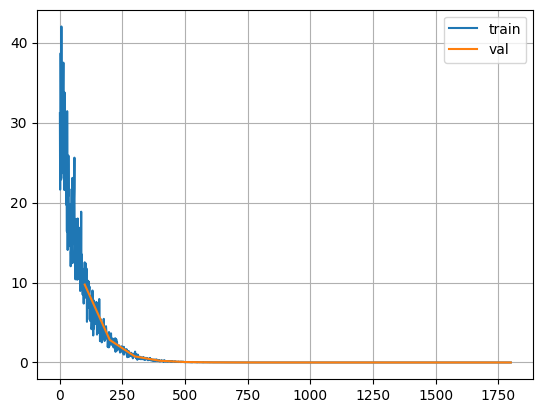

In [154]:
plt.plot([i["step"] for i in record["train"]], [i["loss"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record["val"]], [i["loss"] for i in record["val"]], label="val")
plt.grid()
plt.legend()
plt.show()

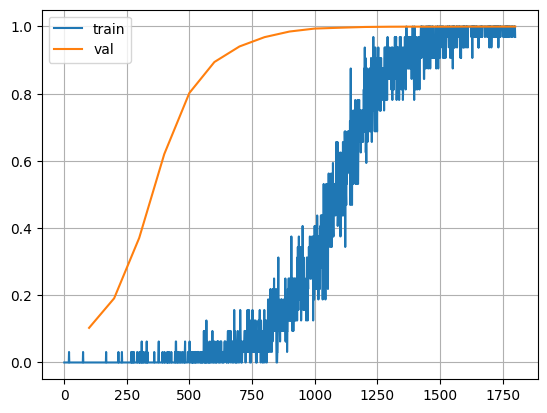

In [155]:
plt.plot([i["step"] for i in record["train"]], [i["acc"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record["val"]], [i["acc"] for i in record["val"]], label="val")
plt.grid()
plt.legend()
plt.show()

In [156]:
loss, acc = evaluating2(linreg, data_loader(batch_size=32, features = X_test, labels = y_test), loss_square)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")


loss:     0.0000
accuracy: 1.0000


# 2.2

In [168]:
# 加载数据
batch_size = 32
train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_ds = TensorDataset(X_val, y_val)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_ds = TensorDataset(X_test, y_test)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [169]:
for X,y in val_dl:
    print(X.shape)
    break

torch.Size([32, 2])


In [170]:
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super().__init__()
        self.linear = nn.Linear(n_feature, 1)
        self.init_weights()
    
    
    def init_weights(self):
        """使用 xavier 均匀分布来初始化全连接层、卷积层的权重 W"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    
    def forward(self, x):
        return self.linear(x)

In [171]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=100, save_best_only=True):
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1
        
        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        
    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return
        
        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



In [172]:
@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        # 前向计算
        logits = model(datas)              # 验证集预测
        loss = loss_fct(logits, labels.view(-1, 1))         # 验证集损失
        loss_list.append(loss.item()) # 将验证集损失加入列表
        
        pred_list.extend(logits.cpu().numpy().tolist()) # 将验证集预测结果加入列表
        label_list.extend(labels.cpu().numpy().tolist())# 将验证集真实标签加入列表
        
    acc = accuracy_score(np.round(label_list * 100).astype(int), np.round(pred_list * 100).astype(int)) # 计算验证集准确率
    return np.mean(loss_list), acc # 返回验证集损失均值和准确率

In [173]:
def training(epoch, train_dl, val_dl, model, loss_fn, optimizer, save_ckpt_callback=None,
    early_stop_callback=None, eval_step = 100):
    record_dict = {
        "train":[],
        "val":[]
    }
    global_step = 1
    model.train()
    with tqdm(total=epoch * len(train_dl)) as pbar:
        for epoch_id in range(epoch):
            for x, y in train_dl:
                # 梯度清空
                optimizer.zero_grad()
                y_hat = model(x)
                loss = loss_fn(y_hat, y.view(-1, 1))

                loss.backward()
                optimizer.step()
                
                y_true = np.round(y.detach().cpu().numpy() * 100).astype(int)
                y_pred = np.round(y_hat.detach().cpu().numpy() * 100).astype(int)
                acc = accuracy_score(y_true, y_pred)   
                # record
                record_dict["train"].append({
                    "loss": loss.cpu().item(), "acc":acc ,"step": global_step
                })
                        
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_dl, loss_fn)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()
                    if save_ckpt_callback is not None:
                         save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)
                    
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict


epoch = 30
model = LinearNet(2)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# save best
exp_name = "linear"
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback(f"checkpoints/{exp_name}", save_best_only=True)
# early stop
early_stop_callback = EarlyStopCallback(patience=5)

In [174]:
record = training(epoch=epoch, train_dl=train_dl, val_dl = val_dl, model=model, loss_fn=loss_fn, optimizer=optimizer, save_ckpt_callback=save_ckpt_callback, early_stop_callback=early_stop_callback)

  7%|▋         | 799/11250 [00:04<00:58, 179.14it/s, epoch=2]

Early stop at epoch 2 / global_step 800


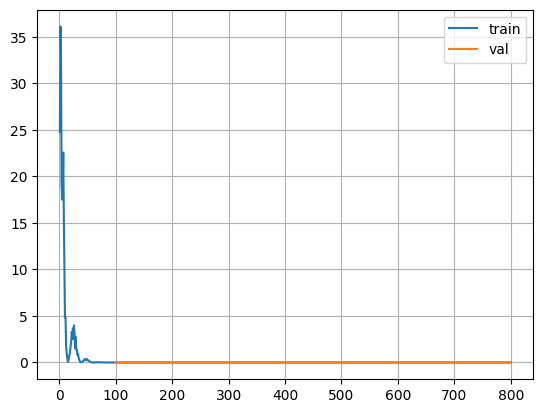

In [175]:
plt.plot([i["step"] for i in record["train"]], [i["loss"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record["val"]], [i["loss"] for i in record["val"]], label="val")
plt.grid()
plt.legend()
plt.show()

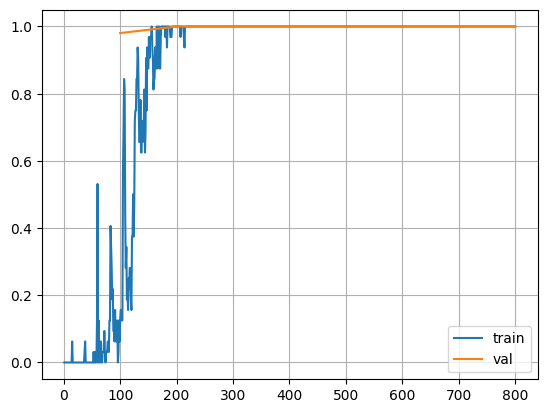

In [176]:
plt.plot([i["step"] for i in record["train"]], [i["acc"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record["val"]], [i["acc"] for i in record["val"]], label="val")
plt.grid()
plt.legend()
plt.show()

## 三、动手实现 softmax 回归

In [197]:
train_ds = torchvision.datasets.FashionMNIST(root='./Datasets/FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
test_ds = torchvision.datasets.FashionMNIST(root='./Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())

In [198]:
seed = 17
train_ds, val_ds = random_split(train_ds, [55000, 5000], torch.Generator().manual_seed(seed))

In [199]:
batch_size = 55
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [200]:
def softmax(logits):
    # 减去最大值（防止指数爆炸）
    max_logits = torch.max(logits, dim=-1, keepdim=True).values  # 形状: (32, 1)
    shifted_logits = logits - max_logits  # 形状: (32, 10)
    
    exp_logits = torch.exp(shifted_logits)
    sum_exp = torch.sum(exp_logits, dim=-1, keepdim=True)
    probs = exp_logits / sum_exp
    return probs

In [201]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating3(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        # 前向计算
        logits = model(datas)              # 验证集预测
        logits = softmax(logits)
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item()) # 将验证集损失加入列表
        
        preds = logits.argmax(axis=-1)    # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist()) # 将验证集预测结果加入列表
        label_list.extend(labels.cpu().numpy().tolist())# 将验证集真实标签加入列表
        
    acc = accuracy_score(label_list, pred_list) # 计算验证集准确率
    return np.mean(loss_list), acc # 返回验证集损失均值和准确率


In [215]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating4(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        # 前向计算
        logits = model(datas)              # 验证集预测
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item()) # 将验证集损失加入列表
        
        preds = logits.argmax(axis=-1)    # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist()) # 将验证集预测结果加入列表
        label_list.extend(labels.cpu().numpy().tolist())# 将验证集真实标签加入列表
        
    acc = accuracy_score(label_list, pred_list) # 计算验证集准确率
    return np.mean(loss_list), acc # 返回验证集损失均值和准确率


In [202]:
# 交叉熵损失函数
def cross_entropy(pred, label):
    if label.dim() == 1:
        label = F.one_hot(label, num_classes=10).float()
    
    loss = - (label * torch.log(pred)).sum(dim=1).mean()
    return loss


In [203]:
class MnistNet(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_features, 392),
            nn.ReLU(),
            nn.Linear(392, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )
        self.init_weight()
    
    
    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
                
                
    def forward(self, x):
        return self.sequential(x)

In [204]:
def training(epoch, train_dl, val_dl, optimizer,  model, loss_fn, save_ckpt_callback=None, early_stop_callback=None,eval_step=500):
    model.train()
    record_dict = {
        "train": [],
        "val":[]
    }
    
    global_step = 0
    with tqdm(total=epoch * len(train_dl)) as pbar:
        for epoch_id in range(epoch):
            for data, label in train_dl:
                optimizer.zero_grad()
                logits=model(data)
                logits = softmax(logits)
                loss = loss_fn(logits, label)
                preds = logits.argmax(axis=-1)
                loss.backward()
                optimizer.step()
                
                acc = accuracy_score(label.cpu().numpy(), preds.cpu().numpy())   
                loss = loss.cpu().item()
                
                record_dict["train"].append({
                        "loss": loss,  "acc":acc, "step": global_step
                    })
                
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating3(model, val_dl, loss_fn)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()
                    
               
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)
    
    
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
            
    return record_dict           
            

In [205]:
epoch = 20
model=MnistNet(784)
optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

loss_fn=cross_entropy

if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/Mnist", save_best_only=True)
early_stop_callback=EarlyStopCallback()

record = training(epoch, train_dl, val_dl, optimizer, model, loss_fn, save_ckpt_callback, early_stop_callback)

 55%|█████▌    | 11000/20000 [02:11<01:47, 83.96it/s, epoch=10]

Early stop at epoch 11 / global_step 11000


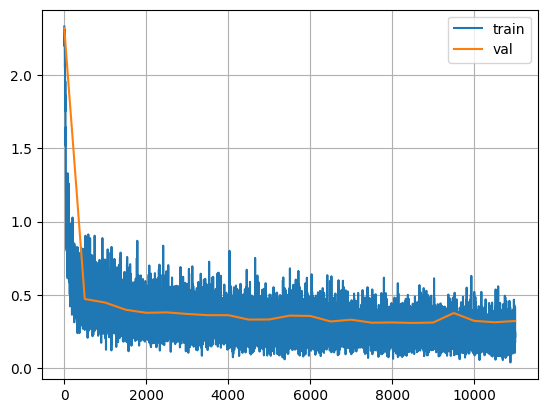

In [206]:
plt.plot([i["step"] for i in record["train"]], [i["loss"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record["val"]], [i["loss"] for i in record["val"]], label="val")
plt.grid()
plt.legend()
plt.show()

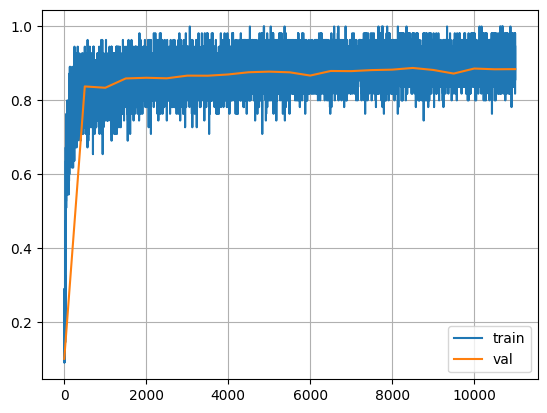

In [207]:
plt.plot([i["step"] for i in record["train"]], [i["acc"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record["val"]], [i["acc"] for i in record["val"]], label="val")
plt.grid()
plt.legend()
plt.show()

In [208]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load(f"checkpoints/Mnist/best.ckpt", map_location="cpu"))

model.eval()
loss, acc = evaluating(model, test_dl, loss_fn)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.3454
accuracy: 0.8774


# 3.2

In [216]:
def training(epoch, train_dl, val_dl, optimizer,  model, loss_fn, save_ckpt_callback=None, early_stop_callback=None,eval_step=500):
    model.train()
    record_dict = {
        "train": [],
        "val":[]
    }
    
    global_step = 0
    with tqdm(total=epoch * len(train_dl)) as pbar:
        for epoch_id in range(epoch):
            for data, label in train_dl:
                optimizer.zero_grad()
                logits=model(data)
                loss = loss_fn(logits, label)
                preds = logits.argmax(axis=-1)
                loss.backward()
                optimizer.step()
                
                acc = accuracy_score(label.cpu().numpy(), preds.cpu().numpy())   
                loss = loss.cpu().item()
                
                record_dict["train"].append({
                        "loss": loss,  "acc":acc, "step": global_step
                    })
                
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating4(model, val_dl, loss_fn)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()
                    
               
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)
    
    
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
            
    return record_dict           
            

In [217]:
epoch = 20
model=MnistNet(784)
optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 损失函数中自动计算softmax
loss_fn=nn.CrossEntropyLoss()

if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/Mnist2", save_best_only=True)
early_stop_callback=EarlyStopCallback()

record = training(epoch, train_dl, val_dl, optimizer, model, loss_fn, save_ckpt_callback, early_stop_callback)

 78%|███████▊  | 15500/20000 [02:59<00:52, 86.20it/s, epoch=15]

Early stop at epoch 15 / global_step 15500


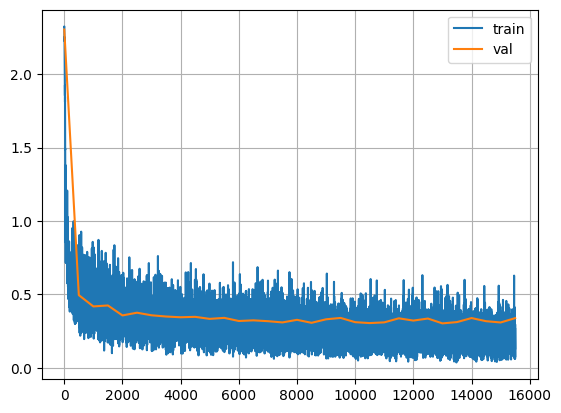

In [218]:
plt.plot([i["step"] for i in record["train"]], [i["loss"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record["val"]], [i["loss"] for i in record["val"]], label="val")
plt.grid()
plt.legend()
plt.show()

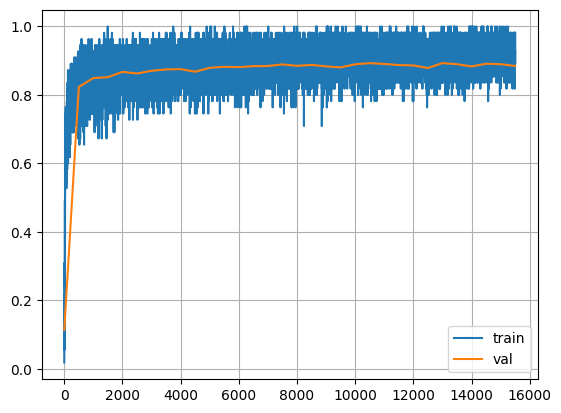

In [219]:
plt.plot([i["step"] for i in record["train"]], [i["acc"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record["val"]], [i["acc"] for i in record["val"]], label="val")
plt.grid()
plt.legend()
plt.show()

In [220]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load(f"checkpoints/Mnist2/best.ckpt", map_location="cpu"))

model.eval()
loss, acc = evaluating(model, test_dl, loss_fn)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     1.5980
accuracy: 0.8900
